<a href="https://colab.research.google.com/github/JoHyunjeong/Deep_learning/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D_%EC%8B%A4%EC%8A%B5/5_%20%EC%8B%9C%EA%B3%84%EC%97%B4%20%EC%98%88%EC%B8%A1%20%EB%B0%8F%20%EC%9E%90%EC%97%B0%EC%96%B4%20%EC%B2%98%EB%A6%AC%20%EB%AA%A8%EB%8D%B8%EB%A7%81/Ch01_LSTM%E1%84%8B%E1%85%B3%E1%86%AF_%E1%84%92%E1%85%AA%E1%86%AF%E1%84%8B%E1%85%AD%E1%86%BC%E1%84%92%E1%85%A2_%E1%84%8C%E1%85%AE%E1%84%80%E1%85%A1_%E1%84%8B%E1%85%A8%E1%84%8E%E1%85%B3%E1%86%A8_%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF_%E1%84%80%E1%85%AE%E1%84%92%E1%85%A7%E1%86%AB%E1%84%92%E1%85%A1%E1%84%80%E1%85%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주제 : LSTM을 활용해 주가 예측 모델 구현하기

이번 튜토리얼 에서는 다음과 같은 **프로세스 파이프라인**으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## Step 1. 데이터 불러오기 및 EDA

### 문제 01. 필요한 모듈 import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

### 문제 02. FinanceDataReader import

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

- [GitHub Repo](https://github.com/FinanceData/FinanceDataReader)

**FinanceDataReader**가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.

In [ ]:
!pip install finance-datareader

In [ ]:
import FinanceDataReader as fdr

### 문제 03. 삼성전자 데이터 불러오기

In [ ]:
# fdr 라이브러리를 활용해 삼성전자 주가 데이터를 불러오세요.
# 대상 : 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

### 문제 04. 삼성전자 데이터 EDA

In [ ]:
samsung.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-01-16,1181,1181,1107,1182,1567730,NaN
1998-01-17,1181,1216,1143,1198,534260,0.013536
1998-01-19,1270,1292,1234,1293,435010,0.079299
1998-01-20,1394,1394,1348,1394,1571310,0.078113
1998-01-21,1388,1388,1283,1320,1163080,-0.053085


In [ ]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-02-22,73000,73400,72800,73400,11692469,-0.010782
2022-02-23,73800,73800,72800,73000,10397964,-0.005450
2022-02-24,72300,72300,71300,71500,15759283,-0.020548
2022-02-25,72100,72600,71900,71900,13168484,0.005594
2022-02-28,71100,72100,71000,72100,17640567,0.002782


In [ ]:
samsung.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6000 entries, 1998-01-16 to 2022-02-28
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    6000 non-null   int64  
 1   High    6000 non-null   int64  
 2   Low     6000 non-null   int64  
 3   Close   6000 non-null   int64  
 4   Volume  6000 non-null   int64  
 5   Change  5999 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 328.1 KB


In [ ]:
samsung.describe()

,Open,High,Low,Close,Volume,Change
count,6000.000000,6000.000000,6000.000000,6000.000000,6.000000e+03,5999.000000
mean,22730.015167,22967.301167,22486.508500,22751.524000,2.955937e+06,0.000997
std,19959.267088,20128.763125,19778.394329,19949.725677,6.700118e+06,0.025030
min,0.000000,0.000000,0.000000,638.000000,0.000000e+00,-0.137566
25%,8687.500000,8800.000000,8580.000000,8717.500000,2.867542e+05,-0.011925
50%,15200.000000,15300.000000,15000.000000,15180.000000,4.700420e+05,0.000000
75%,29465.000000,29780.000000,29200.000000,29500.000000,8.961528e+05,0.012766
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07,0.150000


**미국 주식 데이터**도 가져올 수 있습니다.

### 문제 05. 애플 데이터 불러오기

In [ ]:
# fdr 라이브러리를 활용해 Apple(AAPL) 데이터를 불러오세요.
apple = fdr.DataReader('AAPL')

### 문제 06. 애플 데이터 EDA

In [ ]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-12-12,0.13,0.13,0.13,0.13,469030000.0,-0.9988
1980-12-15,0.12,0.12,0.12,0.12,175880000.0,-0.0769
1980-12-16,0.11,0.11,0.11,0.11,105730000.0,-0.0833
1980-12-17,0.12,0.12,0.12,0.12,86440000.0,0.0909
1980-12-18,0.12,0.12,0.12,0.12,73450000.0,0.0000


In [ ]:
apple.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-02-18,167.30,169.82,170.54,166.19,82770000.0,-0.0094
2022-02-22,164.32,164.98,166.69,162.15,90460000.0,-0.0178
2022-02-23,160.07,165.54,166.15,159.75,88500000.0,-0.0259
2022-02-24,162.74,152.58,162.85,152.00,140170000.0,0.0167
2022-02-25,164.85,163.84,165.12,160.87,91970000.0,0.0130


In [ ]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10390 entries, 1980-12-12 to 2022-02-25
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   10390 non-null  float64
 1   Open    10390 non-null  float64
 2   High    10390 non-null  float64
 3   Low     10390 non-null  float64
 4   Volume  10390 non-null  float64
 5   Change  10390 non-null  float64
dtypes: float64(6)
memory usage: 568.2 KB


### 문제 07. 특정 시점(2017년) 이후 데이터 불러오기

In [ ]:
# Apple(AAPL), 2017년
apple = fdr.DataReader('AAPL', '2017')

In [ ]:
apple.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


### 문제 08. 날짜를 지정하여 특정 범위(40년간) 데이터 불러오기

In [ ]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30') # 회사 code, 특정 범위 시작 날짜, 끝 날짜

In [ ]:
ford.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [ ]:
ford.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


### 문제 09. '금'과 '달러' 데이터도 가져올 수 있습니다. 두 데이터를 불러와 head를 출력해보세요.

*[GitHub 페이지 링크](https://github.com/FinanceData/FinanceDataReader) 참고

In [ ]:
# 금 선물 가격
gold = fdr.DataReader('ZG')

In [ ]:
gold.head()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-01-02,575.5,562.5,577.0,558.0,7260.0,0.0785
1980-01-03,625.0,627.0,640.0,603.0,20750.0,0.0860
1980-01-04,603.6,609.5,621.0,573.0,2660.0,-0.0342
1980-01-07,627.0,629.0,635.0,611.0,3000.0,0.0388
1980-01-08,602.5,611.5,619.0,600.0,750.0,-0.0391


In [ ]:
gold.tail()

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2022-02-18,1899.8,1901.4,1905.0,1888.0,161750.0,-0.0012
2022-02-22,1907.4,1903.5,1918.3,1889.7,334590.0,-0.0024
2022-02-23,1910.4,1901.2,1912.9,1891.1,154840.0,0.0016
2022-02-24,1926.3,1911.9,1976.5,1878.6,423050.0,0.0083
2022-02-25,1887.6,1906.5,1925.0,1884.4,229780.0,-0.0201


In [ ]:
# 달러 가격
dollar = fdr.DataReader('USD/KRW')

In [ ]:
dollar.head()

,Close,Open,High,Low,Change
Date,,,,,
1981-04-14,676.70,676.70,676.70,676.70,0.0019
1981-04-15,676.70,676.70,676.70,676.70,0.0000
1981-04-16,676.70,676.70,676.70,676.70,0.0000
1981-04-17,676.75,676.75,676.75,676.75,0.0001
1981-04-20,676.70,676.70,676.70,676.70,-0.0001


In [ ]:
dollar.tail()

,Close,Open,High,Low,Change
Date,,,,,
2022-02-23,1192.44,1193.03,1194.34,1189.64,0.0005
2022-02-24,1206.05,1192.60,1211.47,1191.93,0.0114
2022-02-25,1197.57,1206.11,1206.90,1197.73,-0.0070
2022-02-27,1197.83,1197.83,1197.83,1197.83,0.0002
2022-02-28,1202.69,1197.83,1208.79,1197.83,0.0041


### 문제 10. 삼성전자 데이터를 STOCK_CODE에 저장하고 인덱스를 확인해보세요

In [ ]:
# 문제 03과 코드는 동일합니다.
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [ ]:
# fdr 라이브러리를 활용해 삼성전자 데이터를 불러오세요 
stock = fdr.DataReader(STOCK_CODE)
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1998-01-16,1181,1181,1107,1182,1567730,NaN
1998-01-17,1181,1216,1143,1198,534260,0.013536
1998-01-19,1270,1292,1234,1293,435010,0.079299
1998-01-20,1394,1394,1348,1394,1571310,0.078113
1998-01-21,1388,1388,1283,1320,1163080,-0.053085


In [ ]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-02-22,73000,73400,72800,73400,11692469,-0.010782
2022-02-23,73800,73800,72800,73000,10397964,-0.005450
2022-02-24,72300,72300,71300,71500,15759283,-0.020548
2022-02-25,72100,72600,71900,71900,13168484,0.005594
2022-02-28,71100,72100,71000,72100,17640567,0.002782


In [ ]:
# 인덱스를 확인해보세요.
stock.index # 날짜 인덱스

DatetimeIndex(['1998-01-16', '1998-01-17', '1998-01-19', '1998-01-20',
               '1998-01-21', '1998-01-22', '1998-01-23', '1998-01-24',
               '1998-01-26', '1998-01-30',
               ...
               '2022-02-15', '2022-02-16', '2022-02-17', '2022-02-18',
               '2022-02-21', '2022-02-22', '2022-02-23', '2022-02-24',
               '2022-02-25', '2022-02-28'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

## Step 2. 시계열 데이터 시각화


### 문제 11. 인덱스가 `DatetimeIndex`로 정의되어 있다면, 연도, 월, 일을 쪼갤 수 있습니다. 데이터를 분리해주세요.

In [ ]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [ ]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1998-01-16,1181,1181,1107,1182,1567730,NaN,1998,1,16
1998-01-17,1181,1216,1143,1198,534260,0.013536,1998,1,17
1998-01-19,1270,1292,1234,1293,435010,0.079299,1998,1,19
1998-01-20,1394,1394,1348,1394,1571310,0.078113,1998,1,20
1998-01-21,1388,1388,1283,1320,1163080,-0.053085,1998,1,21


### 문제 12. 연도별, 월별 피봇테이블을 각각 구현해보세요.

In [ ]:
stock.groupby('Month').mean()

,Open,High,Low,Close,Volume,Change,Year,Day
Month,,,,,,,,
1,24657.932540,24967.255952,24354.101190,24655.220238,3.745762e+06,0.003066,2010.265873,16.289683
2,23738.405063,23980.567511,23480.839662,23719.691983,2.965345e+06,-0.000149,2009.812236,14.915612
3,21892.132948,22144.177264,21648.473988,21901.204239,3.230639e+06,0.001602,2009.396917,16.487476
4,22566.915020,22774.644269,22315.288538,22655.426877,2.420356e+06,0.001142,2009.488142,15.642292
5,21708.016598,21908.603734,21464.033195,21887.331950,3.153023e+06,-0.001821,2009.290456,16.943983
6,22246.885312,22468.344064,22014.917505,22234.384306,3.046314e+06,0.000611,2009.426559,15.895372
7,22513.443182,22731.604167,22295.577652,22514.770833,2.524384e+06,0.001757,2009.535985,16.018939
8,21915.794574,22128.930233,21674.184109,21881.304264,2.883159e+06,-0.000198,2009.352713,16.048450
9,22133.176471,22358.210084,21917.468487,22150.065126,2.784597e+06,-0.000693,2009.315126,15.189076


In [ ]:
stock.groupby(['Year','Month']).mean() # 연도별 월별 평균

Open          High  ...    Change        Day
Year Month                              ...                     
1998 1       1354.454545   1378.818182  ...  0.033309  22.636364
     2       1527.791667   1569.083333  ...  0.006900  15.000000
     3       1529.615385   1567.423077  ... -0.012408  16.192308
     4       1266.192308   1302.423077  ...  0.002643  15.500000
     5       1123.500000   1149.500000  ... -0.014984  16.875000
...                  ...           ...  ...       ...        ...
2021 10     70852.631579  71373.684211  ... -0.003077  16.631579
     11     71863.636364  72386.363636  ...  0.001077  14.954545
     12     77522.727273  78272.727273  ...  0.004349  15.681818
2022 1      76885.000000  77300.000000  ... -0.003220  15.500000
     2      73866.666667  74211.111111  ... -0.000864  15.277778

[290 rows x 7 columns]

### 문제 13. matplotlib을 활용해 시간에 따른 주식 가격 시계열 그래프를 그려보세요.

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


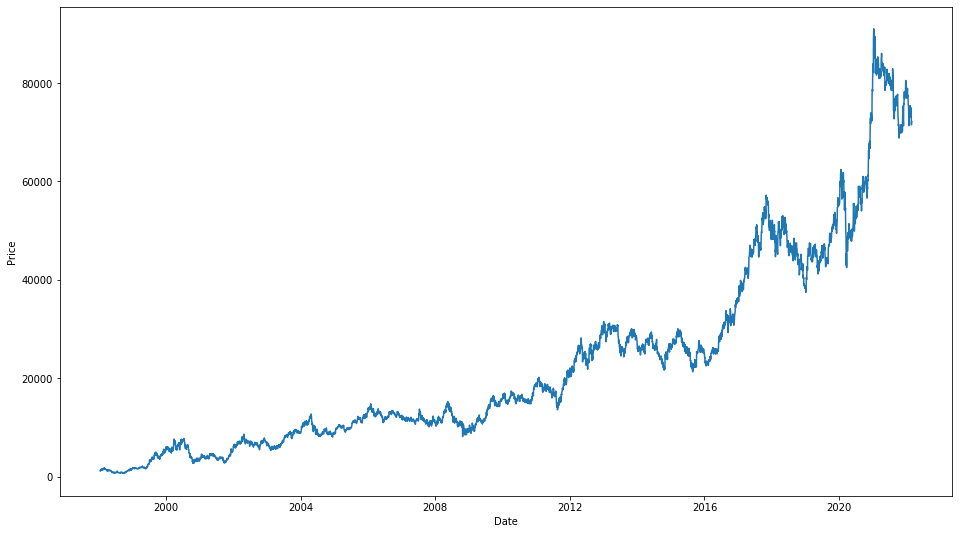

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(stock['Close'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

### 문제 14. subplots를 활용해 그래프 4개(2,2)를 동시에 그려보세요.

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


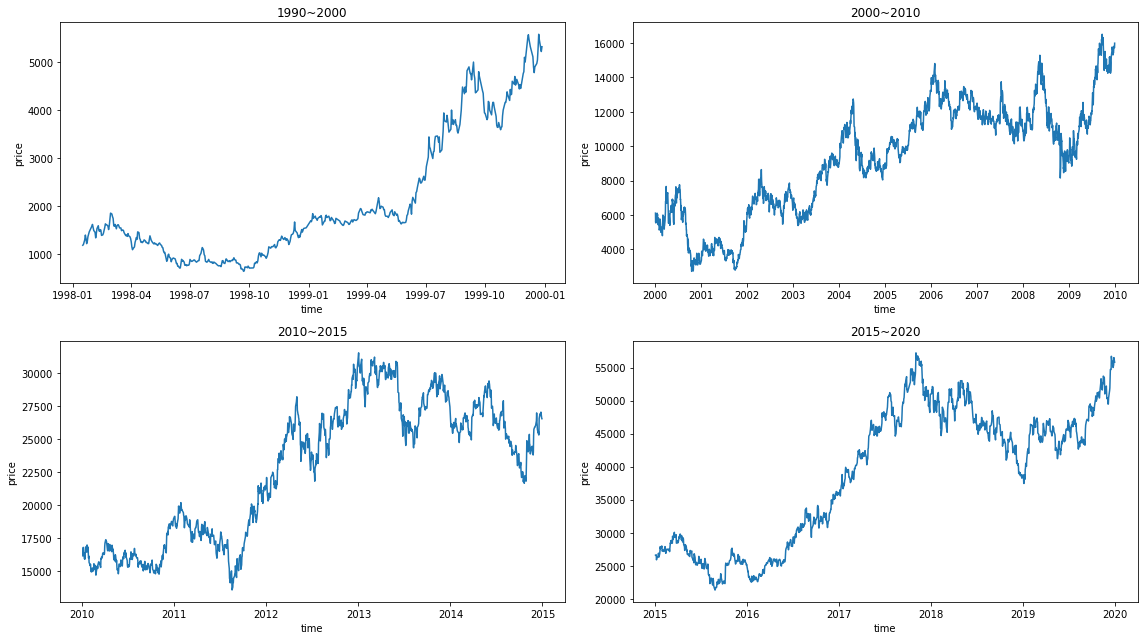

In [ ]:
# 1990~2000, 2000~2010, 2010~2015, 2015~2020
time_steps = [['1990', '2000'],
              ['2000', '2010'],
              ['2010', '2015'],
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)

for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index >= time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, data=df, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')

plt.tight_layout()
plt.show()

## Step 3. 시계열 데이터의 전처리

### 문제 15. MinMaxScaler를 활요해 데이터 전처리를 수행합니다.

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [ ]:
#MinMaxScaler 할당
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open','High','Low','Close','Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])

In [ ]:
scaled.min(), scaled.max() # 0~1 사이 값으로 변환됨

(0.0, 1.0)

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [ ]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [ ]:
df.head()

,Open,High,Low,Close,Volume
0,0.013079,0.012200,0.012369,0.006020,0.017360
1,0.013079,0.012562,0.012771,0.006197,0.005916
2,0.014064,0.013347,0.013788,0.007249,0.004817
3,0.015437,0.014401,0.015061,0.008366,0.017400
4,0.015371,0.014339,0.014335,0.007547,0.012879


### 문제 16. 모델 학습을 위해 train 데이터와 test 데이터로 분할해주세요.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'],
                                                    test_size=0.2, random_state=0, shuffle=False)

### 문제 17. train 데이터와 test 데이터의 shape을 각각 살펴봅니다.

In [ ]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [ ]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

### 문제 18. TensorFlow Dataset을 활용해 시퀀스 데이터셋을 함수로 구현해주세요

windowed_dataset  
  
window 범위를 만들어서 window가 하나씩 shift되는 dataset

In [ ]:
import tensorflow as tf

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle): # window_size -> 과거 몇 일치 데이터를 볼 건지
    series = tf.expand_dims(series, axis=-1) # 종가 데이터 / 차원 하나 늘려줌
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # window size는 x와 y의 범위를 포함하여 설정 / drop_remainder -> 꼬다리 버리기
    ds = ds.flat_map(lambda w: w.batch(window_size + 1)) # flat_map : [[1][2][3]] -> [1,2,3] flat하게 묶어줌
    if shuffle: # train_dataset은 overfitting 방지를 위해 shuffle 사용
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1])) # x, y 나눠주기
    return ds.batch(batch_size).prefetch(1)

## Step 4. 모델 구현하기

### 문제 19. Hyperparameter를 정의하고 데이터에 적용해주세요.

In [ ]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [ ]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
# WINDOW_SIZE와 BATCH_SIZE를 각 데이터셋에 적용해주세요.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다. 데이터의 shape을 살펴보세요.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


### 문제 20. Sequential 모델을 구현합니다. 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda # Lambda Layer는 중간에 scale up할 때 많이 사용됨
from tensorflow.keras.losses import Huber # 특정 임계값 이내는 MSE(L2), 임계값 밖은 MAE(L1) loss
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성합니다. filters는 32로, kernel_size는 5로 지정해주세요.
    # LSTM과 Dense 레이어를 사용해주세요. 필요한 경우 활성함수는 relu로 지정합니다.
    Conv1D(filters=32, kernel_size=5, # 특정 패턴(주기) 파악 / kernel_size=5 -> 5일씩 나눠서 특성 추출
           padding='causal', # padding='casual' -> size가 줄어들지 않고 앞 부분에 zero padding
           activation='relu',
           input_shape=[WINDOW_SIZE, 1]),
    LSTM(16), # MANY TO ONE model
    Dense(16, activation='relu'),
    Dense(1),
])

### 문제 21. 모델을 Compile합니다. loss는 Huber 함수를 사용하고 optimizer는 Adam을 사용해주세요.

In [ ]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
model.compile(loss=loss, optimizer='adam', metrics=['mse'])

In [ ]:
# earlystopping은 10번 epoch 동안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = 'tmp_checkpoint.ckpt' # 중간중간 성능이 잘나온 모델의 가중치 저장
checkpoint = ModelCheckpoint(filepath=filename,
                             save_best_only=True,
                             save_weights_only=True,
                             monitor='val_loss',
                             verbose=1,)

In [ ]:
# callbacks로 앞에서 구현한 earlystopping과 checkpoint를 지정해주세요.
history = model.fit(train_data, 
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[earlystopping, checkpoint]
                    )

Epoch 1/50
    150/Unknown - 13s 7ms/step - loss: 5.8080e-05 - mse: 1.1616e-04
Epoch 1: val_loss improved from inf to 0.00378, saving model to tmp_checkpoint.ckpt
150/150 [==============================] - 14s 14ms/step - loss: 5.8080e-05 - mse: 1.1616e-04 - val_loss: 0.0038 - val_mse: 0.0076
Epoch 2/50
142/150 [===========================>..] - ETA: 0s - loss: 2.3191e-05 - mse: 4.6382e-05
Epoch 2: val_loss improved from 0.00378 to 0.00190, saving model to tmp_checkpoint.ckpt
150/150 [==============================] - 1s 8ms/step - loss: 2.4195e-05 - mse: 4.8389e-05 - val_loss: 0.0019 - val_mse: 0.0038
Epoch 3/50
145/150 [============================>.] - ETA: 0s - loss: 2.1145e-05 - mse: 4.2291e-05
Epoch 3: val_loss improved from 0.00190 to 0.00164, saving model to tmp_checkpoint.ckpt
150/150 [==============================] - 1s 8ms/step - loss: 2.1457e-05 - mse: 4.2914e-05 - val_loss: 0.0016 - val_mse: 0.0033
Epoch 4/50
147/150 [============================>.] - ETA: 0s - loss: 2.04

## Step 5. 모델을 활용한 예측 및 결과 시각화

### 문제 24. 저장한 ModelCheckpoint 를 불러옵니다.

In [ ]:
model.load_weights(filename)

### 문제 25. `test_data`를 활용하여 예측을 수행합니다.

In [ ]:
pred = model.predict(test_data)

In [ ]:
pred

array([[0.5052331 ],
       [0.50362384],
       [0.5046999 ],
       ...,
       [0.80925304],
       [0.801681  ],
       [0.7958529 ]], dtype=float32)

### 문제 26. matplotlib을 활용해 예측 데이터를 시각화해주세요.

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

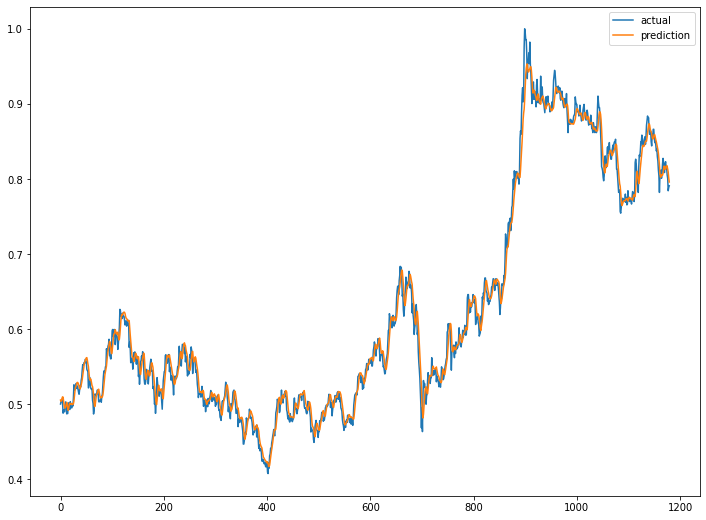

In [ ]:
# 20일치의 데이터로 21일치를 예측하므로 test_data 사용시 이전 20일은 예측하지 않습니다.
# 따라서 y_test 데이터에 [20:]로 슬라이싱해주세요.
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()